# Main Purpose: Creating a csv file to feed in a ML model 
#### (Multiple csv files were exported as a checkpoint)

Summary of Procedures Performed: 
1. Creating one big file of More2 data by combining all the json files
2. Filtering our working data to patients with diabetes
3. Filtering our working data to patients with specific diabetes codes that Inovalon has data of
4. Filtering our working data to patients who went through discharge
5. Label readmission events and define targets (0 or 1)
6. Finalize csv to feed into the ML model 


## Assumptions

- Only used claims that have diabetes with following code: ICD10CM- 
- Only considered patients with following events: Observtion, Observation Stay, Inpatient Stay, Nonacute Inpatient (only CPT), Nonacute Inpatient Stay as denominator 
- Discharge corresponds to the patient with Observtion, Observation Stay, Inpatient Stay, Nonacute Inpatient (only CPT), Nonacute Inpatient Stay and a discharge code (DSCHRG-)
- Readmission labels (given 1) are given to patients with following conditions after discharge: Observtion, Observation Stay, Inpatient Stay, Nonacute Inpatient (only CPT), Nonacute Inpatient Stay, ED, acute inpatient (only CPT)
- Official discharge date is the last discharged date for non-PCR patient and first discharged date with PCR code for PCR patients

In [1]:
#importing necessary libraries
import numpy as np
import py7zr
import os
import pandas as pd
import ast
from datetime import datetime
import matplotlib.pyplot as plot
import re

cwd=os.getcwd()
cwd

'C:\\Users\\david.ma\\Prediction Model'

In [7]:
#directory where json files are stored
json_list='C:\\Users\\david.ma\\Prediction Model\\More2\\'

#reading each jsonfile and attaching to empty array
json_dir=os.listdir(json_list)
empty=[]
for i in range(1,len(json_dir)):
    df = pd.read_json(json_list+str(json_dir[i]),lines=True)
    empty.append(df)

#vertically concatenating all files in array
vertical_concat = pd.concat(empty, axis=0)

In [8]:
#exporting as csv for all the claim data with json files 
export_csv = vertical_concat.to_csv (cwd+'\\allClaims.csv', index = None, header=True)

# Filtering Working dataset to patients with diabetes

In [2]:
#loading csv file
read = pd.read_csv(cwd+'\\allClaims.csv')

In [3]:
#loading csv file containing all diabetes value sets
diab_only = pd.read_csv(cwd+'\\diabetes_filter.csv')

In [4]:
#filtering to specific MORE2 code that we have available
x='ICD10CM'
diab_only=diab_only[diab_only['Code System'].str.contains(x)]

In [5]:
#Relabelling patient code according to dataset
diab_only['Code_new']='ICD10DX-'+diab_only["Code"].str.replace(".","",regex=True)

In [6]:
#appending all diabetes-related codes
string=""
for i in range(0,len(diab_only['Code_new'])):
    if i==0:
        string=str(diab_only['Code_new'][i])
        
    else:
        string=string +'|'+str(diab_only['Code_new'][i])
        #print(string)    

In [7]:
#filtering to diabetic patients only
x=string
diab=read[read['codes'].str.contains(x)]

# Filtering Working Dataset to Diabetic Patients with specific code systems

In [9]:
#exporting and loading the csv file
export_csv = diab.to_csv (cwd+'\\workingdata.csv', index = None, header=True)
diabetes_file = pd.read_csv(cwd+'\\workingdata.csv')
inpatient_observation_file = pd.read_csv(cwd+'\\inpatient_observation_stay_filter.csv',dtype = {'Code':np.str_})

In [10]:
#finding necessary value set codes and relabelling them to match dataset used
inpatient_observation_file['Code_new']='Computer'
for i in range(0,len(inpatient_observation_file["Code"])):
    if inpatient_observation_file['Code System'][i]=='UBREV':
        inpatient_observation_file['Code_new'][i]='REV-'+str(inpatient_observation_file["Code"][i])

    elif inpatient_observation_file['Code System'][i]=='UBTOB':
        inpatient_observation_file['Code_new'][i]='TOB2-'+str(inpatient_observation_file["Code"][i][1:3])

    elif inpatient_observation_file['Code System'][i]=='CPT':
        inpatient_observation_file['Code_new'][i]='CPT-'+str(inpatient_observation_file["Code"][i])

In [11]:
#filtering file to targeted patient codes
UBREV = inpatient_observation_file['Code System'] == 'UBREV'
UBTOB = inpatient_observation_file['Code System'] == 'UBTOB'
CPT = inpatient_observation_file['Code System'] == 'CPT'
inpatient_observation_file = inpatient_observation_file[UBREV|UBTOB|CPT]
inpatient_observation_file

,Value Set Name,Value Set OID,Value Set Version,Code,Definition,Code System,Code System OID,Code System Version,Code_new
0,Inpatient Stay,2.16.840.1.113883.3.464.1004.1395,2020-07-01,0100,NaN,UBREV,2.16.840.1.113883.6.301.3,2012.05,REV-0100
1,Inpatient Stay,2.16.840.1.113883.3.464.1004.1395,2020-07-01,0101,NaN,UBREV,2.16.840.1.113883.6.301.3,2012.05,REV-0101
2,Inpatient Stay,2.16.840.1.113883.3.464.1004.1395,2020-07-01,0110,NaN,UBREV,2.16.840.1.113883.6.301.3,2012.05,REV-0110
3,Inpatient Stay,2.16.840.1.113883.3.464.1004.1395,2020-07-01,0111,NaN,UBREV,2.16.840.1.113883.6.301.3,2012.05,REV-0111
4,Inpatient Stay,2.16.840.1.113883.3.464.1004.1395,2020-07-01,0112,NaN,UBREV,2.16.840.1.113883.6.301.3,2012.05,REV-0112
...,...,...,...,...,...,...,...,...,...
273,Observation,2.16.840.1.113883.3.464.1004.1191,2020-07-01,99219,NaN,CPT,2.16.840.1.113883.6.12,2020.3.19AB,CPT-99219
274,Observation,2.16.840.1.113883.3.464.1004.1191,2020-07-01,99220,NaN,CPT,2.16.840.1.113883.6.12,2020.3.19AB,CPT-99220
275,Observation Stay,2.16.840.1.113883.3.464.1004.1461,2020-07-01,0760,NaN,UBREV,2.16.840.1.113883.6.301.3,2012.05,REV-0760
276,Observation Stay,2.16.840.1.113883.3.464.1004.1461,2020-07-01,0762,NaN,UBREV,2.16.840.1.113883.6.301.3,2012.05,REV-0762


In [12]:
#combining code to regex it
string = "|".join(inpatient_observation_file['Code_new'])         

In [13]:
#finding the codes in our currently working dataset
x=string
new_diab=diabetes_file[diabetes_file['codes'].str.contains(x)]

In [15]:
#exporting and loading the csv file
export_csv = new_diab.to_csv (cwd+'\\final_diab.csv', index = None, header=True)
new_diab = pd.read_csv(cwd+'\\final_diab.csv')

# Finding diabetic patients with discharge statuses

In [16]:
#find discharge data and making a dataframe with its code
ID_discharge=pd.read_csv(cwd+'\\dischargestatus_medref.txt', sep='\t')

ID_discharge['DischargeCode']='ComputerScience'
for i in range(len(ID_discharge['DischargeStatusCode'])):
    ID_discharge['DischargeCode'][i]='DSCHRG-'+str(ID_discharge['DischargeStatusCode'][i]).zfill(2)

<ipython-input-16-1da8586a3592>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID_discharge['DischargeCode'][i]='DSCHRG-'+str(ID_discharge['DischargeStatusCode'][i]).zfill(2)


In [17]:
#dropping invalid discharge codes that does not apply
ID_discharge.drop([1,4,8,62,64,65,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94])

,DischargeStatusCodeID,DischargeStatusCode,Description,CodeEffectiveDate,CodeTerminationDate,InLatestFileInd,DischargeCode
0,1,1,DISCHARGED TO HOME OR SELF CARE (ROUTINE DISCH...,1/1/1998,NaN,1,DSCHRG-01
2,3,3,DISCHARGED/TRANSFERRED TO SKILLED NURSING FACI...,1/1/1998,NaN,1,DSCHRG-03
3,4,4,DISCHARGED/TRANSFERRED TO A FACILITY THAT PROV...,1/1/1998,NaN,1,DSCHRG-04
5,6,6,DISCHARGED/TRANSFERRED TO HOME UNDER CARE OF O...,1/1/1998,NaN,1,DSCHRG-06
6,7,7,LEFT AGAINST MEDICAL ADVICE OR DISCONTINUED CARE,1/1/1998,NaN,1,DSCHRG-07
...,...,...,...,...,...,...,...
79,80,80,RESERVED FOR NATIONAL ASSIGNMENT,NaN,7/9/2019,1,DSCHRG-80
95,96,96,RESERVED FOR NATIONAL ASSIGNMENT,NaN,7/1/2019,1,DSCHRG-96
96,97,97,RESERVED FOR NATIONAL ASSIGNMENT,NaN,7/1/2019,1,DSCHRG-97
97,98,98,RESERVED FOR NATIONAL ASSIGNMENT,NaN,7/1/2019,1,DSCHRG-98


In [18]:
#updating working dataset with patients who experienced discharge
string = "|".join(ID_discharge['DischargeCode'])
x=string
new_diab=new_diab[new_diab['codes'].str.contains(x)]

In [20]:
#day computation function given two dates: 
def date_converter(previous,after):
    """Retrieves two dates in form yyyy-mm-dd and computes the day difference between them

    Input
    --
    previous: first date
    after: second date
    
    Output
    --
    days: day difference between input
    
    """
    
    first=datetime(int(previous[0:4]),int(previous[5:7]),int(previous[8:10]))
    second=datetime(int(after[0:4]),int(after[5:7]),int(after[8:10]))
    
    return (second-first).days

In [21]:
#evaluating expression nodes
new_diab['service_date'] = new_diab['service_date'].apply(ast.literal_eval)
new_diab['codes'] = new_diab['codes'].apply(ast.literal_eval)

In [22]:
#combining the "service date" and codes into a single dictionary in "service and code" column where the dates are the keys and codes are the values
new_diab['Service and Code']='compsci'
for i in new_diab.index:
    new_diab['Service and Code'][i]=dict(zip(new_diab['service_date'].loc[i], new_diab['codes'].loc[i]))

<ipython-input-22-fe24d8f4b209>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_diab['Service and Code'][i]=dict(zip(new_diab['service_date'].loc[i], new_diab['codes'].loc[i]))


In [23]:
#defining new variable to represent the dictionary column
SC=new_diab['Service and Code']

In [24]:
#initializing "filtered service and code" column
new_diab['Filtered Service and Code']='Computer Science'

# Identifying Readmission Codes that will be used for our working dataset

In [25]:
#importing readmission codes
readmission_sets = pd.read_csv(cwd+'\\readmission_valuesets.csv',dtype = {'Code':np.str_})

In [26]:
#Relabelling codes for readmission
readmission_sets['Code_new']='Computer'
for i in range(0,len(readmission_sets["Code"])):
    if readmission_sets['Code System'][i]=='UBREV':
        readmission_sets['Code_new'][i]='REV-'+str(readmission_sets["Code"][i])

    elif readmission_sets['Code System'][i]=='UBTOB':
        readmission_sets['Code_new'][i]='TOB2-'+str(readmission_sets["Code"][i][1:3])

    elif readmission_sets['Code System'][i]=='CPT':
        readmission_sets['Code_new'][i]='CPT-'+str(readmission_sets["Code"][i])  

In [27]:
#filtering value sets to usable ones
UBREV = readmission_sets['Code System'] == 'UBREV'
UBTOB = readmission_sets['Code System'] == 'UBTOB'
CPT = readmission_sets['Code System'] == 'CPT'
readmission_sets = readmission_sets[UBREV|UBTOB|CPT]

In [31]:
readmission_sets

,Value Set Name,Value Set OID,Value Set Version,Code,Definition,Code System,Code System OID,Code System Version,Code_new
0,Acute Inpatient,2.16.840.1.113883.3.464.1004.1810,2020-07-01,99221,NaN,CPT,2.16.840.1.113883.6.12,2020.3.19AB,CPT-99221
1,Acute Inpatient,2.16.840.1.113883.3.464.1004.1810,2020-07-01,99222,NaN,CPT,2.16.840.1.113883.6.12,2020.3.19AB,CPT-99222
2,Acute Inpatient,2.16.840.1.113883.3.464.1004.1810,2020-07-01,99223,NaN,CPT,2.16.840.1.113883.6.12,2020.3.19AB,CPT-99223
3,Acute Inpatient,2.16.840.1.113883.3.464.1004.1810,2020-07-01,99231,NaN,CPT,2.16.840.1.113883.6.12,2020.3.19AB,CPT-99231
4,Acute Inpatient,2.16.840.1.113883.3.464.1004.1810,2020-07-01,99232,NaN,CPT,2.16.840.1.113883.6.12,2020.3.19AB,CPT-99232
...,...,...,...,...,...,...,...,...,...
467,Observation,2.16.840.1.113883.3.464.1004.1191,2020-07-01,99219,NaN,CPT,2.16.840.1.113883.6.12,2020.3.19AB,CPT-99219
468,Observation,2.16.840.1.113883.3.464.1004.1191,2020-07-01,99220,NaN,CPT,2.16.840.1.113883.6.12,2020.3.19AB,CPT-99220
469,Observation Stay,2.16.840.1.113883.3.464.1004.1461,2020-07-01,0760,NaN,UBREV,2.16.840.1.113883.6.301.3,2012.05,REV-0760
470,Observation Stay,2.16.840.1.113883.3.464.1004.1461,2020-07-01,0762,NaN,UBREV,2.16.840.1.113883.6.301.3,2012.05,REV-0762


# Labelling Target (Readmission) for Working Dataset 

In [29]:
#Classifying codes used for discharge, readmission and both
random=[]
discharge=[]
readmission_codes=[]

for i in ID_discharge['DischargeCode']:
    random.append(i)
    discharge.append(i)
    
for j in readmission_sets['Code_new']:
    random.append(j)
    readmission_codes.append(j)

In [30]:
#creating dictionary to find if patient was readmitted
new_diab['Discharged date']='today'
for i in new_diab.index:
    new_diab['Filtered Service and Code'][i]={k:v for (k,v) in SC[i].items() if any(substring in v for substring in random)}

<ipython-input-30-cd3f323cbecd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_diab['Discharged date'][i]=[k for (k,v) in SC[i].items() if any(option in v for option in discharge)]
<ipython-input-30-cd3f323cbecd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_diab['Filtered Service and Code'][i]={k:v for (k,v) in SC[i].items() if any(substring in v for substring in random)}


In [34]:
#The following functions perform the following: Find significant date (ex. discharge) by searching through the dates

def importantDates(claim):
    mem_id =claim[0]
    dates = claim[1]
    codes = codesToList(claim[2])
    locations = checkCodes(codes)
    date =[]
    for location in locations:
        date.append(dates[location])
    return date

def checkCodes(codes):
    locations = []
    for index, code in enumerate(codes):
        if any(item in code for item in discharge):
            locations.append(index)
    return locations

def codesToList(codes):
    finalized = []
    for code in codes:
        finalized.append(code.split("|"))
    return finalized

In [35]:
#finding all discharge dates for each patient
new_diab['discharge_dates'] = new_diab.apply(importantDates, axis =1)
data = new_diab[new_diab['discharge_dates'].apply(len) >= 1]

In [37]:
#defining readmission code filter variable
regex = "|".join(readmission_sets['Code_new'])
p = re.compile(regex)

In [38]:
#This function does the following: labels readmission and the patient's corresponding discharge date based on our assumption
def labeling(row):
    for date in row['discharge_dates']:
        z = row['service_date'].index(date)
        within_30 = []
        for dat in row['service_date'][z+1:]:
            if (datetime(int(dat[0:4]),int(dat[5:7]),int(dat[8:10]))-
                 datetime(int(date[0:4]),int(date[5:7]),int(date[8:10]))).days <=30:
                within_30.append(dat)
        for x in within_30:
            if any(p.findall(row['Service and Code'][x])):
                return (date, 1)
            
data['label']= data.apply(labeling, axis =1)                

In [42]:
#labelling the Official discharge date based on our assumptions and target (if readmission occurred)
data['Official Discharge Date']='Comp'
data['Y']='Inovalon'

for i in data.index:
    if data['label'][i]==None:
        data['Official Discharge Date'][i]=data['discharge_dates'][i][-1]
        data['Y'][i]=0
    else:
        data['Official Discharge Date'][i]=data['label'][i][0]
        data['Y'][i]=1


<ipython-input-42-5cebba7e54f4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Official Discharge Date'][i]=data['discharge_dates'][i][-1]
<ipython-input-42-5cebba7e54f4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Y'][i]=0
<ipython-input-42-5cebba7e54f4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Official Discharge Date'][i]=data['label'][i][0]
<ipython-input-42-5cebba7e54f4>:10: SettingWithCopyWarning: 

## Computation of the Readmission Statistics/Descriptions (First PCR event after discharge) 

In [48]:
#Determing the readmission events for each patient
data['Readmission Stats']=None

for i in data.index:
    if data['Y'][i]!=None and data['Y'][i]==1:
        z=iter(list(data['Filtered Service and Code'][i]))
        
        for j in range(len(list(data['Filtered Service and Code'][i]))):
            after=next(z)
            
            if after==data['Official Discharge Date'][i]:
                record=next(z)
                data['Readmission Stats'][i]=p.findall(data['Filtered Service and Code'][i][record])
                break
             

<ipython-input-48-7df31e6154cc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Readmission Stats'][i]=p.findall(data['Filtered Service and Code'][i][record])


In [54]:
###defining variables to filter specific value set codes 

acute_inpatient=readmission_sets['Value Set Name']=='Acute Inpatient'
AcuteInpatient = readmission_sets[acute_inpatient]
AcuteInpatientcodes = "|".join(AcuteInpatient['Code_new'])

observation_stay=readmission_sets['Value Set Name']=='Observation Stay'
ObservationStay = readmission_sets[observation_stay]
ObservationStaycodes = "|".join(ObservationStay['Code_new'])

observation=readmission_sets['Value Set Name']=='Observation'
Observation = readmission_sets[observation]
Observationcodes = "|".join(Observation['Code_new'])

nonacute_inpatient=readmission_sets['Value Set Name']=='Nonacute Inpatient'
NonAcuteInpatient = readmission_sets[nonacute_inpatient]
NonAcuteInpatientcodes = "|".join(NonAcuteInpatient['Code_new'])

nonacute_inpatient_stay=readmission_sets['Value Set Name']=='Nonacute Inpatient Stay'
NonAcuteInpatientStay = readmission_sets[nonacute_inpatient_stay]
NonAcuteInpatientStaycodes = "|".join(NonAcuteInpatientStay['Code_new'])

inpatient_stay=readmission_sets['Value Set Name']=='Inpatient Stay'
InpatientStay = readmission_sets[inpatient_stay]
InpatientStaycodes = "|".join(InpatientStay['Code_new'])

ed=readmission_sets['Value Set Name']=='ED'
ED = readmission_sets[ed]
EDcodes = "|".join(ED['Code_new'])

In [55]:
#appending value set codes to their corresponding array

AcuteInpatientcodes=[]
ObservationStaycodes=[]
Observationcodes=[]
NonAcuteInpatientcodes=[]
NonAcuteInpatientStaycodes=[]
InpatientStaycodes=[]
EDcodes=[]


for i in AcuteInpatient['Code_new']:
    AcuteInpatientcodes.append(i)
    
for j in ObservationStay['Code_new']:
    ObservationStaycodes.append(j)
    
for j in Observation['Code_new']:
    Observationcodes.append(j)
    
for j in NonAcuteInpatient['Code_new']:
    NonAcuteInpatientcodes.append(j)
    
for j in NonAcuteInpatientStay['Code_new']:
    NonAcuteInpatientStaycodes.append(j)
    
for j in InpatientStay['Code_new']:
    InpatientStaycodes.append(j)
    
for j in ED['Code_new']:
    EDcodes.append(j)

In [56]:
#Counting each readmission events

AcIn_count=0
NAcIn_pat_count=0
ED_count=0
In_pat_count=0
Obs_count=0
Obs_stay_count=0
NAcIn_pat_stay_count=0

for i in data.index:
    if data['Readmission Stats'][i]!=None:
        a_counter=0
        b_counter=0
        c_counter=0
        d_counter=0
        e_counter=0
        f_counter=0
        g_counter=0
        
        for j in range(len(data['Readmission Stats'][i])):                     
            
            if data['Readmission Stats'][i][j] in AcuteInpatientcodes and a_counter==0:
                AcIn_count+=1
                a_counter+=1
                
            if data['Readmission Stats'][i][j] in ObservationStaycodes and b_counter==0:
                Obs_stay_count+=1
                b_counter+=1

            if data['Readmission Stats'][i][j] in Observationcodes and c_counter==0:
                Obs_count+=1
                c_counter+=1

            if data['Readmission Stats'][i][j] in NonAcuteInpatientStaycodes and d_counter==0:
                NAcIn_pat_stay_count+=1
                d_counter+=1
                
            if data['Readmission Stats'][i][j] in NonAcuteInpatientcodes and e_counter==0:
                NAcIn_pat_count+=1
                e_counter+=1
                
            if data['Readmission Stats'][i][j] in InpatientStaycodes and f_counter==0:
                In_pat_count+=1
                f_counter+=1
                
            if data['Readmission Stats'][i][j] in EDcodes and g_counter==0:
                ED_count+=1
                g_counter+=1

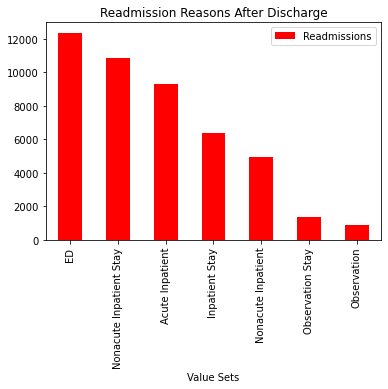

In [60]:
#Plotting the Readmission Events After Discharge for PCR Diabetic Patients
Mydata = {"Value Sets":["Observation","Observation Stay","Nonacute Inpatient","Inpatient Stay","Acute Inpatient","Nonacute Inpatient Stay","ED"][::-1],

        "Readmissions":sorted([AcIn_count,Obs_stay_count,Obs_count,NAcIn_pat_stay_count,NAcIn_pat_count,In_pat_count,ED_count],reverse = True)

        };

dataFrame = pd.DataFrame(Mydata);
dataFrame.plot.bar(x="Value Sets", y="Readmissions", rot=90, title="Readmission Events After Discharge for PCR Diabetic Patients",color='r');
plot.show(block=True);

In [135]:
#eliminating unnecessary columns 
unnecessary=["Service and Code", "Filtered Service and Code","label","discharge_dates","Readmission Stats"]
for i in unnecessary:
    data.pop(i)

#producing input data to feed the model
data['InputData']='yes'
for i in data.index:
    k=list(data['Service and Code'][i])
    ind=k.index(data['Official Discharge Date'][i])
    data['InputData'][i]={k:v for j,(k,v) in enumerate(SC[i].items()) if j<=ind}

In [139]:
#exporting working dataset
final = data.to_csv (cwd+'\\finallabeledData.csv', index = None, header=True)